# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

In [ ]:
COLLABORATORS = "Nawara Joanna, Śliwa Karol, Kopeć Marta"

---

## Zestaw zadań 2: Badanie intensywności procesów punktowych (część 1)

In [ ]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial as spatial
import math

sns.set() 
sns.set_theme(style="whitegrid")

In [ ]:
def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    """
    Parameters
    -------
    intensity: float
        Liczba dodatnia określająca intensywność procesu punktowego.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """ 
    xDelta=x_lim[1]-x_lim[0];
    yDelta=y_lim[1]-y_lim[0];
    areaTotal=xDelta*yDelta;
    
    numbPoints = sp.stats.poisson( intensity*areaTotal ).rvs() 
    x = xDelta*sp.stats.uniform.rvs(0,1,(1, numbPoints))+x_lim[0]
    y = yDelta*sp.stats.uniform.rvs(0,1,(1, numbPoints))+y_lim[0]
    data={'X':x.ravel(), 'Y':y.ravel()}
    return pd.DataFrame(data)

def unhomogeneous_poisson_on_rectangle(intensity_function, x_lim, y_lim):
    """
    Parameters
    -------
    intensity_function: function
        Funkcja przyjmująca dwa argumenty (macierz 1D współrzędnych X i macierz 1D współrzędnych Y) i zwracająca macierz 1D
        z wartościami funkcji opisującej intensywność procesu dla tych współrzędnych.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10] 
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """    
    xMin=x_lim[0];xMax=x_lim[1]; #parametry pomocnicze do uzycia
    yMin=y_lim[0];yMax=y_lim[1];
    xDelta=xMax-xMin;
    yDelta=yMax-yMin;
    areaTotal=xDelta*yDelta;

    #szukanie maximum
    def fun_Neg_intensity(x):
        return -intensity_function(x[0],x[1]); #-f. intensity -> bo bedziemy szukac minimum zamiast maximum

    xy0=[(xMin+xMax)/2,(yMin+yMax)/2]; #poczatkowa wartosc - srodek
    
    #max intensity
    minimizeRes=sp.optimize.minimize(fun_Neg_intensity, xy0, bounds=((xMin, xMax), (yMin, yMax)));
    intensityNegMin=minimizeRes.fun; #minimum z funkcji minimize
    intensityMax=-intensityNegMin; #minimum

    #jednorodny poisson
    numbPoints = np.random.poisson(intensityMax*areaTotal);#ile punktow
    xx = np.random.uniform(0,xDelta,((numbPoints,1)))+xMin;
    yy = np.random.uniform(0,yDelta,((numbPoints,1)))+yMin;
    
    
    #x,y i przerzedzanie  
    p=intensity_function(xx,yy)/intensityMax; #i_punktu/i_max
    thinnedPoints=np.random.uniform(0,1,((numbPoints,1)))<p;

    #x i y ktore zatrzymujemy
    xx=xx[thinnedPoints]; 
    yy=yy[thinnedPoints];
    data={'X':xx.ravel(), 'Y':yy.ravel()}
    return pd.DataFrame(data);

def materna_on_rectangle(parent_intensity, daughter_intensity, cluster_radius, x_lim, y_lim):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    daughter_intensity: float
        Liczba dodatnia określająca intensywność potomnego procesu punktowego.
    cluster_radius: float
        Liczba dodatnia określająca promień generowanych klastrów.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    
    # Extended simulation windows parameters
    x_lim_new = [x_lim[0]-cluster_radius, x_lim[1]+cluster_radius]
    y_lim_new = [y_lim[0]-cluster_radius, y_lim[1]+cluster_radius]
    
    # Simulate Poisson point process for the parents
    parent_points =  homogeneous_poisson_on_rectangle(parent_intensity, x_lim_new, y_lim_new)
    num_parent = len(parent_points)
    
    # Number of daughters points per cluster
    circle_area = np.pi*cluster_radius**2
    num_daughter = sp.stats.poisson( daughter_intensity*circle_area ).rvs()
    
    total_number = num_parent * num_daughter
    
    # Generate polar variables
    r = cluster_radius * np.sqrt(np.random.uniform(0, 1, total_number));
    angle = 2 * np.pi * np.random.uniform(0, 1, total_number);
    
    # Convert from polar to Cartesian coordinates
    daughter_x = r * np.cos(angle)
    daughter_y = r * np.sin(angle)
    
    # Replicate parents
    parent_x = np.repeat(parent_points.X, num_daughter)
    parent_y = np.repeat(parent_points.Y, num_daughter)
    
    # Translate points
    new_x = parent_x + daughter_x
    new_y = parent_y + daughter_y
    
    # Accept points inside the simulation window
    insideWindow = ((new_x >= x_lim[0]) & (new_x <= x_lim[1]) & (new_y >= y_lim[0]) & (new_y <= y_lim[1]))
    new_x = new_x[insideWindow]
    new_y = new_y[insideWindow]
    
    # Pass data to the DataFrame
    data = {'X': new_x, 'Y': new_y}
    data = pd.DataFrame(data)
    
    return data


def thomas_on_rectangle(parent_intensity, mean_cluster_size, cluster_sigma, x_lim, y_lim):
    """
    Parameters
    -------
    parent_intensity: float
        Liczba dodatnia określająca intensywność macierzystego procesu punktowego.
    mean_cluster_size: float
        Liczba dodatnia określająca oczekiwaną liczebność generowanych klastrów.
    cluster_sigma: float
        Liczba dodatnia określająca odchylenie standardowe rozkładu wykorzystywanego w procesie generowania klastrów.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   
    
    Returns
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    """
    # YOUR CODE HERE
    bb = cluster_sigma*4
    x_lim_new = [x_lim[0]-bb, x_lim[1]+bb]
    y_lim_new = [y_lim[0]-bb, y_lim[1]+bb]
    xDeltaExt = x_lim_new[1] - x_lim_new[0];
    yDeltaExt = y_lim_new[1] - y_lim_new[0];
    areaTotalExt = xDeltaExt * yDeltaExt;  # area of extended rectangle

    # Simulate Poisson point process for the parents
    numbPointsParent =  homogeneous_poisson_on_rectangle(parent_intensity, x_lim_new, y_lim_new)
    #numbPointsParent = str(numbPointsParent)
    npp  = len(numbPointsParent)

    # x and y coordinates of Poisson points for the parent
    xxParent = x_lim_new[0] + xDeltaExt * np.random.uniform(0, 1, npp);
    yyParent = y_lim_new[0] + yDeltaExt * np.random.uniform(0, 1, npp);
    
    # Simulate Poisson point process for the daughters (ie final poiint process)
    numbPointsDaughter = np.random.poisson(mean_cluster_size, npp);
    numbPoints = sum(numbPointsDaughter);  # total number of points

    # Generate the (relative) locations in Cartesian coordinates by simulating independent normal variables
    xx0 = np.random.normal(0, cluster_sigma, numbPoints);  # (relative) x coordinaets
    yy0 = np.random.normal(0, cluster_sigma, numbPoints);  # (relative) y coordinates

    # replicate parent points (ie centres of disks/clusters)
    xx = np.repeat(xxParent, numbPointsDaughter);
    yy = np.repeat(yyParent, numbPointsDaughter);

    # translate points (ie parents points are the centres of cluster disks)
    xx = xx + xx0;
    yy = yy + yy0;

    # thin points if outside the simulation window
    booleInside = ((xx >= x_lim[0]) & (xx <= x_lim[1]) & (yy >= y_lim[0]) & (yy <= y_lim[1]));
    # retain points inside simulation window
    xx = xx[booleInside];  
    yy = yy[booleInside];
    
    # Pass data to the DataFrame
    data = {'X': xx, 'Y': yy}
    data = pd.DataFrame(data)
    
    return data
    

### Przygotowanie danych (5 pkt)

Korzystając z funkcji przygotowanych w ramach pierwszego zestawu zadań wygeneruj rozkłady punktowe o podanych paramatrach.

Jednorodny rozkłada Poissona:
 - intensywność procesu: 20
 
Niejednorodny rozkład Poissona:
 - intensywność procesu: f(x, y) = $10(cos(\frac{\pi}{4} x)+1)$

Rozkład Materna:
 - intensywność procesu macierzystego: 0.15
 - intensywność procesu potomnego: 15
 - promień klastra: 1.25
 
Rozkład Thomasa:
 - intensywność procesu macierzystego: 0.3
 - średnia liczebność klastra: 20
 - odchylenie standardowe klastra: 0.75

Parametry identyczne dla wszystkich rozkładów:
 - zakres wartości współrzędnej x: [-10, 10]
 - zakres wartości współrzędnej y: [-5, 5]

In [ ]:
x_lim = [-10, 10]
y_lim = [-5, 5]

def intensity_function(X, Y):
  return 10*(np.cos(X*np.pi/4) + 1)

points_HP = homogeneous_poisson_on_rectangle(20, x_lim, y_lim)
points_UP = unhomogeneous_poisson_on_rectangle(intensity_function, x_lim, y_lim)
points_M = materna_on_rectangle(0.15, 15, 1.25, x_lim, y_lim)
points_T = thomas_on_rectangle(0.3, 20, 0.75, x_lim, y_lim)

### Zadanie 1: Badanie intensywności procesu punktowego metodą szacowania lokalnego (20 pkt)

Przygotuj funkcję `point_count_on_subregions()`, która będzie zliczać punkty w obrębie prostokątnych podobszarów oraz funkcję `intensity_on_subregions()`, która będzie obliczać intensywność procesu punktowego w obrębie prostokątnych podobszarów.

Następnie wykorzystaj przygotowane funkcje do zbadania intensywności wszystkich przygotowanych rozkładów punktów. Ustaw podział obszaru na 40 podobszarów wzdłuż osi $x$ i 20 podobszarów wzdłuż osi $y$.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2).

#### a) Przygotowanie funkcji

In [ ]:
def point_count_on_subregions(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    bin_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
    
    area, borderX, borderY = np.histogram2d(points.X, points.Y, bins, range = [x_lim, y_lim])
    #bin_data = {'X': borderX, 'Y': borderY, 'Area': area.T}
    bin_data = [borderX, borderY, area.T]
    return bin_data
    
    
def intensity_on_subregions(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    intensity_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z wartością intensywności przypisaną do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[9, 12], [13, 8]])]
    """
    
    # Calculate number of points on area
    intensity_data = point_count_on_subregions(points, bins, x_lim, y_lim)
    intensity_data = {'X': intensity_data[0], 'Y': intensity_data[1], 'Area': intensity_data[2]}

    # Calculate intensity
    dx = abs(intensity_data['X'][1] - intensity_data['X'][0])
    dy = abs(intensity_data['Y'][1] - intensity_data['Y'][0])
    areaSubregion = dx * dy

    intensity_data['Area'] = intensity_data['Area'] / areaSubregion

    intensity_data = [intensity_data['X'], intensity_data['Y'], intensity_data['Area']]
    return intensity_data

#### b) Wygenerowanie danych

In [ ]:
bins = [40, 20]

bin_dataHP = point_count_on_subregions(points_HP, bins, x_lim, y_lim)
bin_dataM = point_count_on_subregions(points_M, bins, x_lim, y_lim)
bin_dataT = point_count_on_subregions(points_T, bins, x_lim, y_lim)
bin_dataUP = point_count_on_subregions(points_UP, bins, x_lim, y_lim)

intensity_HP = intensity_on_subregions(points_HP, bins, x_lim, y_lim)
intensity_M = intensity_on_subregions(points_M, bins, x_lim, y_lim)
intensity_T = intensity_on_subregions(points_T, bins, x_lim, y_lim)
intensity_UP = intensity_on_subregions(points_UP, bins, x_lim, y_lim)
#print(intensity_UP)
#print(intensity_HP[0].shape)

[array([-10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,  -6.5,  -6. ,
        -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,  -2. ,  -1.5,
        -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,
         3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,
         8. ,   8.5,   9. ,   9.5,  10. ]), array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]), array([[20., 16., 20., 32., 28.,  8.,  8., 16.,  8., 12.,  4.,  0.,  0.,
         4.,  0.,  4.,  0., 12., 20.,  8., 20., 28., 28.,  8., 12.,  4.,
         4.,  0.,  0.,  0.,  4.,  4., 12., 16.,  8., 20., 20., 20., 16.,
         0.],
       [ 8., 28., 28., 24., 20., 12.,  8., 16.,  0.,  0.,  0.,  0.,  0.,
         4.,  4.,  4., 24., 12., 20., 24.,  8., 12., 20.,  8.,  0.,  8.,
         0.,  0.,  0.,  0.,  4.,  8., 12.,  4., 16., 16.,  8., 12., 16.,
         4.],
       [20., 20., 28., 28., 16., 20., 24., 20., 12.,  4.,  4.,  0.,

#### c) Wizualizacja

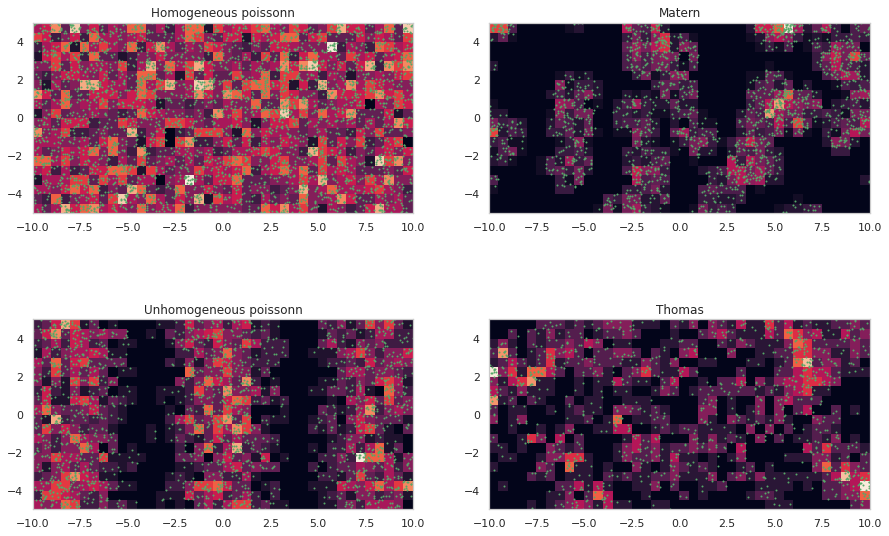

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].pcolormesh(intensity_HP[0], intensity_HP[1], intensity_HP[2])
ax[0,0].scatter(points_HP.X, points_HP.Y, s = 1, c='g')
ax[0,0].set_title("Homogeneous poissonn")
ax[0,0].set_aspect('equal')

ax[0,1].pcolormesh(intensity_M[0], intensity_M[1], intensity_M[2])
ax[0,1].scatter(points_M.X, points_M.Y, s = 1, c='g')
ax[0,1].set_title("Matern")
ax[0,1].set_aspect('equal')

ax[1,0].pcolormesh(intensity_UP[0], intensity_UP[1], intensity_UP[2])
ax[1,0].scatter(points_UP.X, points_UP.Y, s = 1, c='g')
ax[1,0].set_title("Unhomogeneous poissonn")
ax[1,0].set_aspect('equal')

ax[1,1].pcolormesh(intensity_T[0], intensity_T[1], intensity_T[2])
ax[1,1].scatter(points_T.X, points_T.Y, s = 1, c='g')
ax[1,1].set_title("Thomas")
ax[1,1].set_aspect('equal')

plt.show()


### Zadanie 2: Badanie intensywności procesu punktowego metodą funkcji jądrowych (25 pkt)

Przygotuj funkcję `intensity_on_kde()`, która będzie obliczać intensywność procesu punktowego z wykorzystaniem jądrowego estymatora funkcji intensywności danego wzorem:
$$ 	\grave{\lambda}(x,y) = \sum_{d_i < \tau} \frac{3}{\pi \tau^2} (1-\frac{d_i^2}{\tau^2})^2$$ 

gdzie: $d_i$ - odległość punktu od centrum funkcji jądrowej, $\tau$ - promień funkcji jądrowej.

Następnie wykorzystaj przygotowaną funkcje do zbadania intensywności wszystkich przygotowanych rozkładów punktów. Wykonaj obliczania dla promienia funkcji jądrowej równego 1.5 i siatki  200x100 regularnie rozłożonych i pokrywających cały obszar punktów.

Przedstaw wyniki analizy graficznie w postaci wykresów konturowych z wypełnieniem z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2).

Uwaga! Funkcja przygotowana według powyższych wytycznych nie ma wbudowanego mechanizmu korekty na efekt brzegowy, w związu z czym będzie zaniżać wartość intensywności przy krawędziach analizowanego obszaru.

#### a) Przygotowanie funkcji

In [ ]:
def wzor(dis, kernel_radius):
    wart = (3/(math.pi*kernel_radius**2))*(1-((dis**2)/(kernel_radius**2)))**2
    return wart
def intensity_on_kde(points, kernel_radius, grid, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    grid: list
        Lista określająca liczbę punktów w poziomie i pionie, dla których wyliczane będą wartości intensywności.
        Przykład: [10, 10]
    kernel_radius: float
        Liczba dodatnia określająca promień funkcji jądrowej.
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    intensity_data: DataFrame
        Tablica zawierająca trzy kolumny - dwie ze współrzędnymi opisane jako "X" i "Y"
        oraz kolumnę z wartościami intensywności wyliczonymi dla tych współrzędnych opisaną jako "I".
    """
    # Create a tree of points
    p_tree = spatial.cKDTree(points)

    l1 = np.array(np.linspace(x_lim[0], x_lim[1], grid[0]))
    l2 = np.array(np.linspace(y_lim[0], y_lim[1], grid[1]))

    # Table with grid
    tab = np.transpose([np.tile(l1, len(l2)), np.repeat(l2, len(l1))])
    intensity = list()
    table_len = len(tab)

    # Iterate over x, y grid
    for xy in range(table_len):
        # Take current point
        curr = [ tab[xy][0], tab[xy][1] ]
        # All points within distance kernel_radius from current point 
        neighbours =  p_tree.data[p_tree.query_ball_point(curr , kernel_radius)]
        # List to store all results from intensity function
        results = []

        for xy2 in range(len(neighbours)):
            # Calculate distance between points
            dis = math.hypot(neighbours[xy2][0]-curr[0], neighbours[xy2][1]-curr[1])
            # Get value from kernel density estimator
            function_val = wzor(dis, kernel_radius)
            results.append(function_val)    

        intensity_val = sum(results)
        intensity.append(intensity_val)

    df_XY = pd.DataFrame(tab , columns = ['X', 'Y'])
    df_I = pd.DataFrame(intensity, columns = ['I'])
    final = pd.concat([df_XY,df_I], axis = 1)
    final = final.dropna(axis=0)
    return final



#### b) Wygenerowanie danych

In [ ]:
kernel_radius = 1.5
grid = [200, 100]
x_lim = [-10,10]
y_lim = [-5,5]

int_pointsHP = intensity_on_kde(points_HP, kernel_radius, grid, x_lim, y_lim)
int_pointsM = intensity_on_kde(points_M, kernel_radius, grid, x_lim, y_lim)
int_pointsT = intensity_on_kde(points_T, kernel_radius, grid, x_lim, y_lim)
int_pointsUP = intensity_on_kde(points_UP, kernel_radius, grid, x_lim, y_lim)


#### c) Wizualizacja

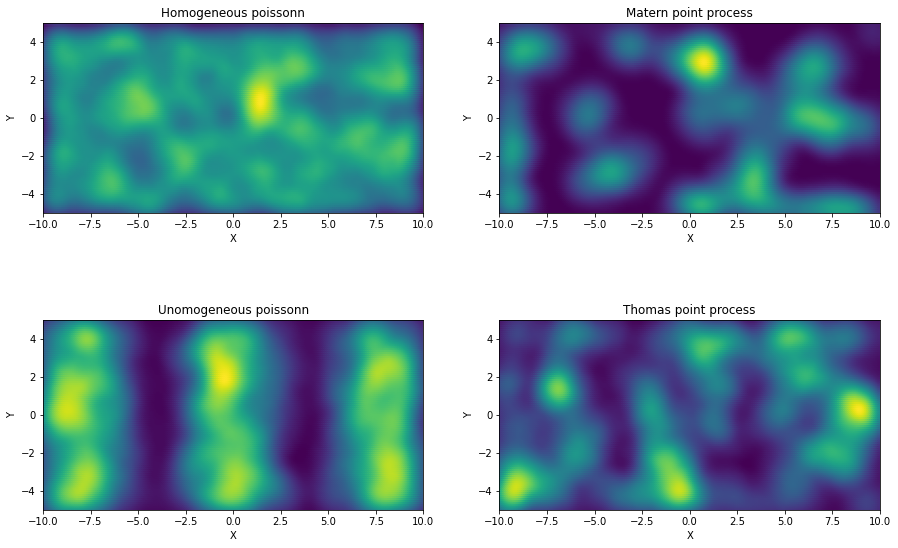

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

ax[0,0].scatter(int_pointsHP['X'], int_pointsHP['Y'], c = int_pointsHP['I'])
ax[0,0].set_aspect('equal')
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)
ax[0,0].set_title("Homogeneous poissonn")
ax[0,0].set_xlabel("X")
ax[0,0].set_ylabel("Y")

ax[1,0].scatter(int_pointsUP['X'], int_pointsUP['Y'], c = int_pointsUP['I'])
ax[1,0].set_aspect('equal')
ax[1,0].set_xlim(x_lim)
ax[1,0].set_ylim(y_lim)
ax[1,0].set_title("Unomogeneous poissonn")
ax[1,0].set_xlabel("X")
ax[1,0].set_ylabel("Y")

ax[0,1].scatter(int_pointsM['X'], int_pointsM['Y'], c = int_pointsM['I'])
ax[0,1].set_aspect('equal')
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)
ax[0,1].set_title("Matern point process")
ax[0,1].set_xlabel("X")
ax[0,1].set_ylabel("Y")

ax[1,1].scatter(int_pointsT['X'], int_pointsT['Y'], c = int_pointsT['I'])
ax[1,1].set_aspect('equal')
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)
ax[1,1].set_title("Thomas point process")
ax[1,1].set_xlabel("X")
ax[1,1].set_ylabel("Y")

plt.show()